# Testing prompts for Classifying emails

## Importing libraries

In [1]:
import os
import numpy as np
import requests
from dotenv import load_dotenv
from langsmith import traceable
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    accuracy_score, confusion_matrix, hamming_loss
)
import re

import warnings
warnings.filterwarnings("ignore")

### Getting Path of current file
import os
import sys
from pathlib import Path

path = Path(os.path.dirname(os.getcwd()))
path = str(path)
print(path)
sys.path.insert(1, path)

/Users/saideepbunny/Projects/Email-Assistant-using-Generative-AI


## Setting API keys

In [2]:
load_dotenv(dotenv_path=f"{path}/config/nvidia_token.env")

model1 = "google/gemma-3n-e4b-it"
model2 = "mistralai/mistral-nemotron"
model3 = "meta/llama-4-maverick-17b-128e-instruct"

token = os.getenv("NVIDIA_API_KEY")

## Classification function

In [3]:
def classify_email(model, token, prompt_msg, email_content: str, examples: list = None):
    """
    Classify emails using an NVIDIA LLM with optional few-shot examples.

    Args:
        model (str): NVIDIA LLM model name.
        token (str): API key for NVIDIA LLM.
        prompt_msg (str): Classification instruction message.
        email_content (str): Email text to classify.
        examples (list, optional): Few-shot examples in the form 
                                   [{"email": "example email", "label": "JOB"}, ...]

    Returns:
        str: Cleaned classification result (only capital letters).
    """

    # Build few-shot messages
    messages = []

    # Add few-shot examples if provided
    if examples:
        for ex in examples:
            messages.append(("user", ex["email"]))
            messages.append(("assistant", ex["label"]))

    # Add the actual email to classify
    messages.append((
        "user",
        f"""{{email_content}}\n\n{prompt_msg}"""
    ))

    # Create prompt template
    prompt = ChatPromptTemplate.from_messages(messages)

    # Use the NVIDIA LLM via LangChain
    llm = ChatNVIDIA(
        model=model,
        api_key=token,
        temperature=0.2,
        max_tokens=4096,
        streaming=False
    )

    # Define chain
    chain = prompt | llm | StrOutputParser()

    # Run it
    result = chain.invoke({"email_content": email_content})

    # Extract only capital letters (JOB, MEET, OTHER)
    clean_result = re.sub(r'[^A-Za-z,]+', '', result)
    final_result = clean_result.split(",")
    return np.array(final_result)


## Evaluation Function

In [4]:
def evaluate_models_and_plot(df, model_used):
    """
    Evaluates performance metrics and displays a one-row three-column confusion matrix plot 
    for the specified model's predictions against the label columns.

    Parameters:
        df (pd.DataFrame): DataFrame containing columns ['JOB', 'MEET', 'OTHER'] (ground truth) 
                           and model-specific predictions like ['<model>_JOB', '<model>_MEET', '<model>_OTHER']
        model_used (str): The model name prefix used in prediction columns.
    """
    
    original_labels = ['JOB', 'MEET', 'OTHER']
    prediction_labels = [f"{model_used}_{i}" for i in original_labels]

    metrics = {}
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for idx, label in enumerate(original_labels):
        y_true = df[label].astype(int)
        y_pred = df[prediction_labels[idx]].astype(str).str.lower().map({'true': 1, 'false': 0})  # Convert to int

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx])
        axes[idx].set_title(f"{label} Confusion Matrix")
        axes[idx].set_xlabel("Predicted")
        axes[idx].set_ylabel("Actual")
        axes[idx].set_xticklabels(["False", "True"])
        axes[idx].set_yticklabels(["False", "True"])

        # Metrics
        metrics[label] = {
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'accuracy': accuracy_score(y_true, y_pred)
        }

    # Overall metrics
    y_true_all = df[original_labels].astype(int).values
    y_pred_all = df[prediction_labels].astype(str).apply(lambda x: x.str.lower().map({'true': 1, 'false': 0})).values

    metrics['overall'] = {
        'hamming_loss': hamming_loss(y_true_all, y_pred_all),
        'subset_accuracy': accuracy_score(y_true_all, y_pred_all)
    }

    plt.tight_layout()
    plt.show()

    for i,j in metrics.items():
        print(f"{i} : {j}")

## Testing Prompts

### Reading test data

In [5]:
df = pd.read_excel(f"{path}/data/email_classification_annotated_data.xlsx", sheet_name="updated_annotated_data")
df

,email,JOB,MEET,OTHER
0,"Hi Saideep,\n\nThanks for your interest in iSp...",True,False,False
1,"Hello, Saideep,\n\nWe received your job applic...",True,False,False
2,"Hi Saideep,\n\nWe're super-pumped that you sha...",True,False,False
3,"Hi Saideep,\n\nThank you for applying to the S...",True,False,False
4,"Hello Saideep,\n\nThank you for your interest ...",True,False,False
5,"Dear Saideep,\n\nThank you for your interest i...",True,False,False
6,"Dear Saideep,\n\nThank you for your interest i...",True,False,False
7,"Hi Saideep,\nThank you for your interest in th...",True,False,False
8,"Hi Saideep,\n\nThanks for your interest in Red...",True,False,False
9,"Dear Saideep,\n\nThank you for giving us the o...",True,False,False


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   50 non-null     object
 1   JOB     50 non-null     bool  
 2   MEET    50 non-null     bool  
 3   OTHER   50 non-null     bool  
dtypes: bool(3), object(1)
memory usage: 678.0+ bytes


### Prompt-1 test

In [7]:
prompt1 = """You are an expert email classification system. Your task is to analyze the provided email and classify it into all possible of three categories below. Your response must be **only** the True/False for each category without any additional text or metadata.

### **Categories**

**1. JOB**
Classify an email as `JOB` if it concerns the status of a specific job application. Recipient of the mail will be informed about the status of their application. This includes notifications that a candidate has:
*   Successfully applied/in the process of applying for a job (application confirmation).
*   Been shortlisted for a position.
*   Been invited to an interview or assessment.
*   Been rejected for a position.

**2. MEET**
Classify an email as `MEET` if the sender is requesting to schedule a meeting, virtual or in-person.

**3. OTHER**
Classify an email as `OTHER` if it does not fit into the `JOB` or `MEET` categories. This includes, but is not limited to:
*   General job-related discussions that are not about application status (e.g., networking, asking about a role, advertisements, job suggestions or requesting for an interview).
*   Newsletters, marketing emails, personal correspondence, etc.

### **Output Format**

Your answer must be three True or False values, one for each JOB, MEET and OTHER in this exact order:
<is a JOB>, <is a MEET>, <is OTHER>"""

In [8]:
data_df = df.copy()
data_df[['gemma_JOB', 'gemma_MEET', 'gemma_OTHER']] = (
    data_df['email']
    .apply(lambda x: classify_email(model1, token, prompt1, x))
    .apply(pd.Series)  # convert array to 3 separate columns
)

data_df[['mistral_JOB', 'mistral_MEET', 'mistral_OTHER']] = (
    data_df['email']
    .apply(lambda x: classify_email(model2, token, prompt1, x))
    .apply(pd.Series)  # convert array to 3 separate columns
)

data_df[['llama_JOB', 'llama_MEET', 'llama_OTHER']] = (
    data_df['email']
    .apply(lambda x: classify_email(model3, token, prompt1, x))
    .apply(pd.Series)  # convert array to 3 separate columns
)

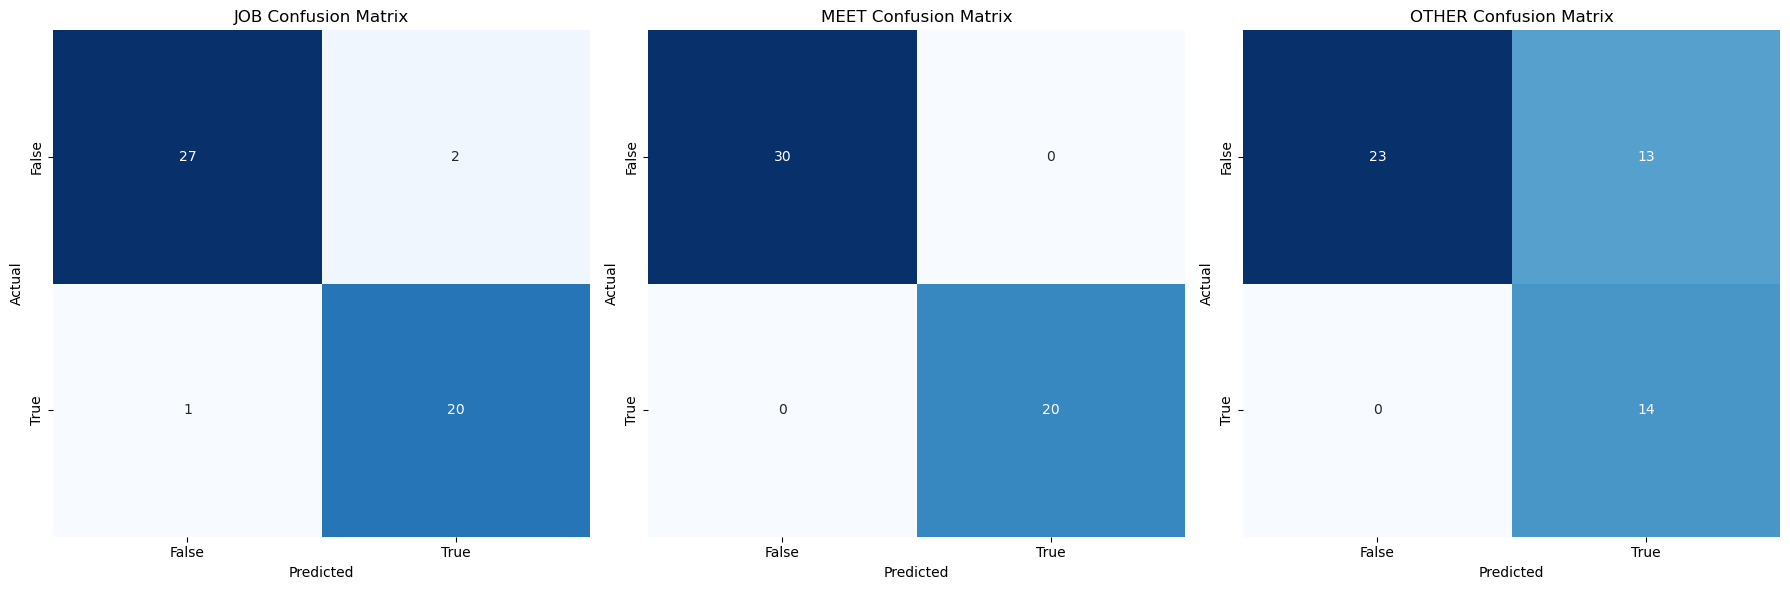

JOB : {'precision': 0.9090909090909091, 'recall': 0.9523809523809523, 'f1': 0.9302325581395349, 'accuracy': 0.94}
MEET : {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}
OTHER : {'precision': 0.5185185185185185, 'recall': 1.0, 'f1': 0.6829268292682927, 'accuracy': 0.74}
overall : {'hamming_loss': 0.10666666666666667, 'subset_accuracy': 0.7}


In [9]:
evaluate_models_and_plot(data_df, model_used="gemma")

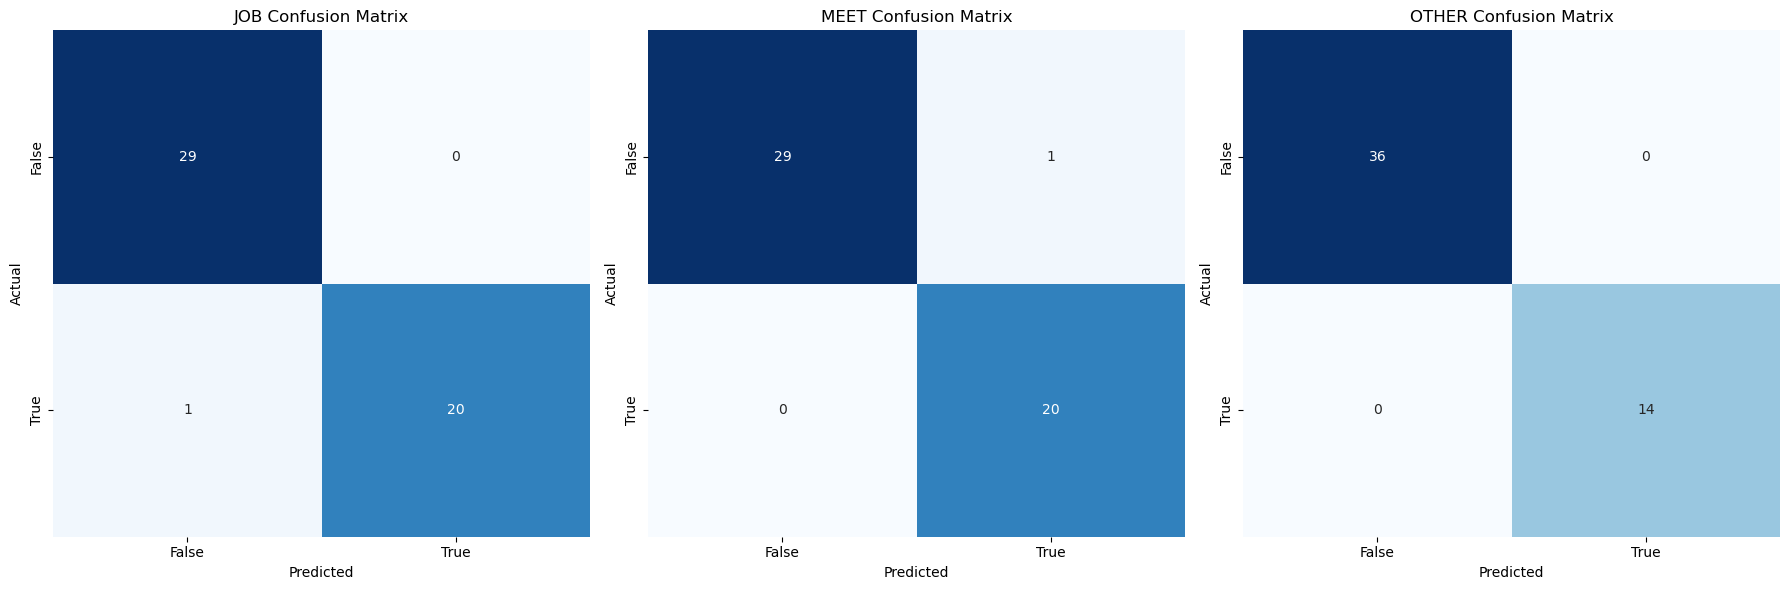

JOB : {'precision': 1.0, 'recall': 0.9523809523809523, 'f1': 0.975609756097561, 'accuracy': 0.98}
MEET : {'precision': 0.9523809523809523, 'recall': 1.0, 'f1': 0.975609756097561, 'accuracy': 0.98}
OTHER : {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}
overall : {'hamming_loss': 0.013333333333333334, 'subset_accuracy': 0.96}


In [10]:
evaluate_models_and_plot(data_df, model_used="mistral")

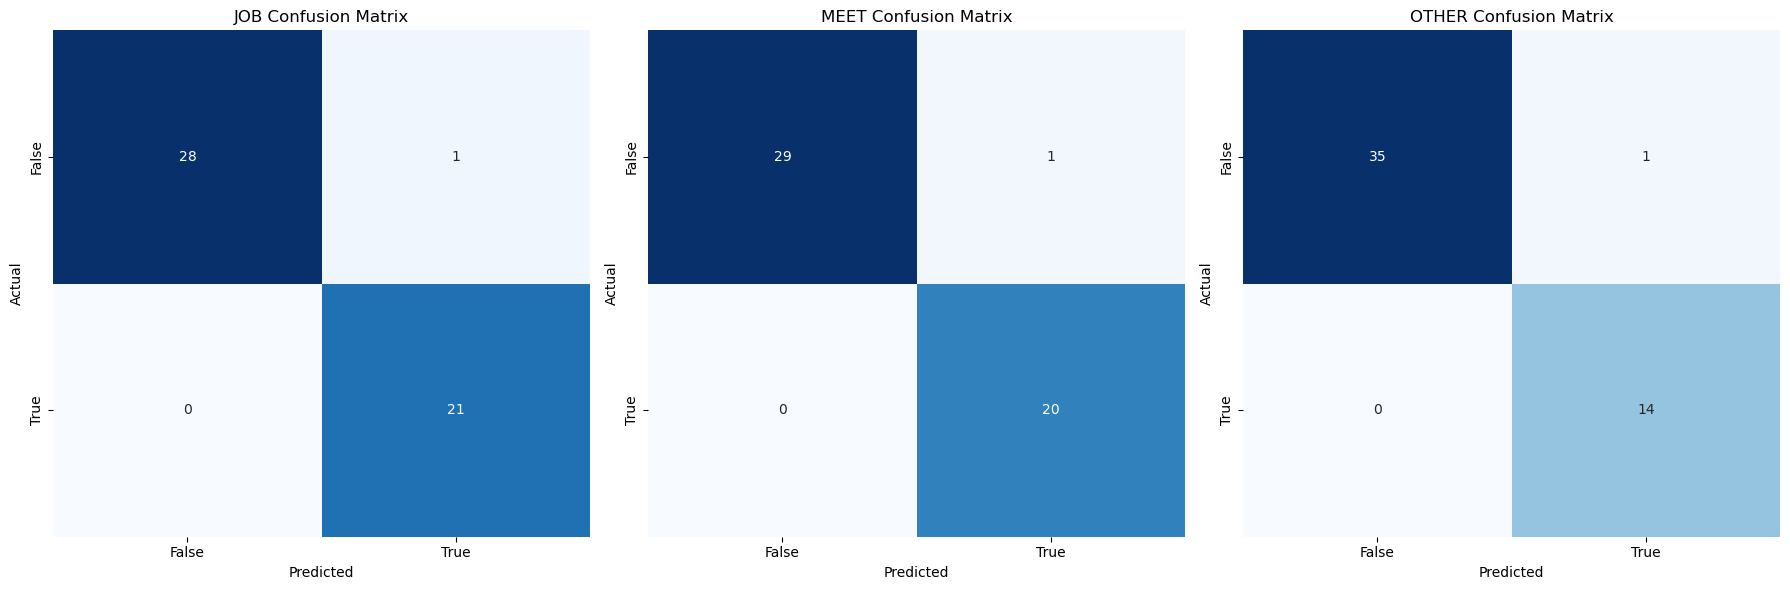

JOB : {'precision': 0.9545454545454546, 'recall': 1.0, 'f1': 0.9767441860465116, 'accuracy': 0.98}
MEET : {'precision': 0.9523809523809523, 'recall': 1.0, 'f1': 0.975609756097561, 'accuracy': 0.98}
OTHER : {'precision': 0.9333333333333333, 'recall': 1.0, 'f1': 0.9655172413793104, 'accuracy': 0.98}
overall : {'hamming_loss': 0.02, 'subset_accuracy': 0.94}


In [11]:
evaluate_models_and_plot(data_df, model_used="llama")

### Prompt-2 test

In [12]:
prompt2 = """You are an expert email classification system. Your task is to analyze the provided email and classify it into all possible of three categories below. Your response must be **only** the True/False for each category without any additional text or metadata.

### **Categories**

**1. JOB**
Classify an email as `JOB` if it concerns the status of a specific job application. Recipient of the mail will be informed about the status of their application. This includes notifications that a candidate has:
*   Successfully applied/in the process of applying for a job (application confirmation).
*   Been shortlisted for a position.
*   Been invited to an interview or assessment.
*   Been rejected for a position.

**2. MEET**
Classify an email as `MEET` if the sender is requesting to schedule a meeting, virtual or in-person.
*   Can be a virtual meeting via Zoom, Google Meet, Teams, Video call, etc.
*   Can be an in-person meeting at a specific location.
*   Can be an invitation to job interviews, assessments as well.

**3. OTHER**
Classify an email as `OTHER` only if it does not fit into the `JOB` or `MEET` categories. This includes, but is not limited to:
*   General job-related discussions that are not about application status (e.g., networking, asking about a role, advertisements, job suggestions or requesting for an interview).
*   Newsletters, marketing emails, personal correspondence, etc.

**Important Rules:**
*   An email cannot be classified as any other class if it classifies as OTHER.
*   An email can be classified either JOB or either MEET or BOTH.
*   Possible combinations of classifications are:
    *   JOB, MEET
    *   JOB
    *   MEET
    *   OTHER

### **Output Format**

Your answer must be three True or False values, one for each JOB, MEET and OTHER in this exact order:
<is a JOB>, <is a MEET>, <is OTHER>"""

In [13]:
data_df = df.copy()
data_df[['gemma_JOB', 'gemma_MEET', 'gemma_OTHER']] = (
    data_df['email']
    .apply(lambda x: classify_email(model1, token, prompt2, x))
    .apply(pd.Series)  # convert array to 3 separate columns
)

data_df[['mistral_JOB', 'mistral_MEET', 'mistral_OTHER']] = (
    data_df['email']
    .apply(lambda x: classify_email(model2, token, prompt2, x))
    .apply(pd.Series)  # convert array to 3 separate columns
)

data_df[['llama_JOB', 'llama_MEET', 'llama_OTHER']] = (
    data_df['email']
    .apply(lambda x: classify_email(model3, token, prompt2, x))
    .apply(pd.Series)  # convert array to 3 separate columns
)

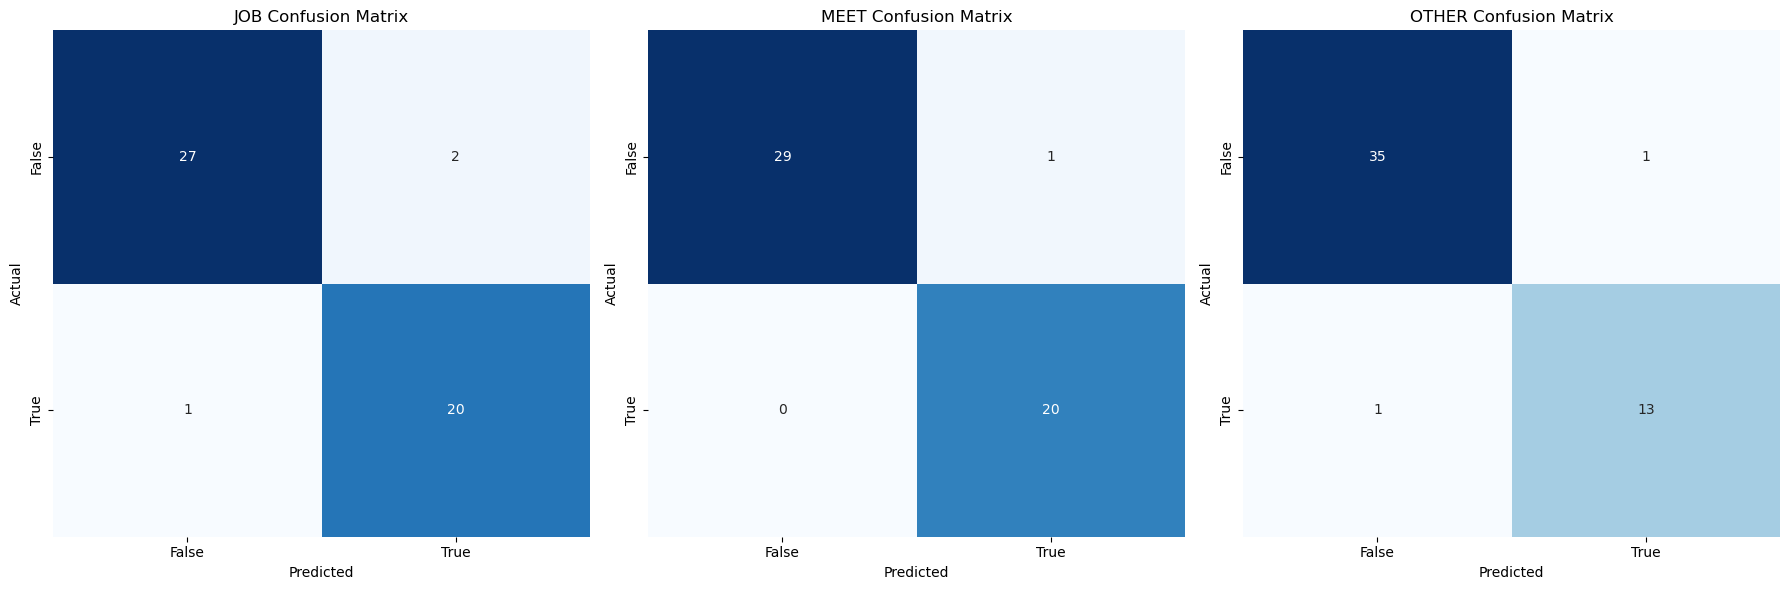

JOB : {'precision': 0.9090909090909091, 'recall': 0.9523809523809523, 'f1': 0.9302325581395349, 'accuracy': 0.94}
MEET : {'precision': 0.9523809523809523, 'recall': 1.0, 'f1': 0.975609756097561, 'accuracy': 0.98}
OTHER : {'precision': 0.9285714285714286, 'recall': 0.9285714285714286, 'f1': 0.9285714285714286, 'accuracy': 0.96}
overall : {'hamming_loss': 0.04, 'subset_accuracy': 0.92}


In [14]:
evaluate_models_and_plot(data_df, model_used="gemma")

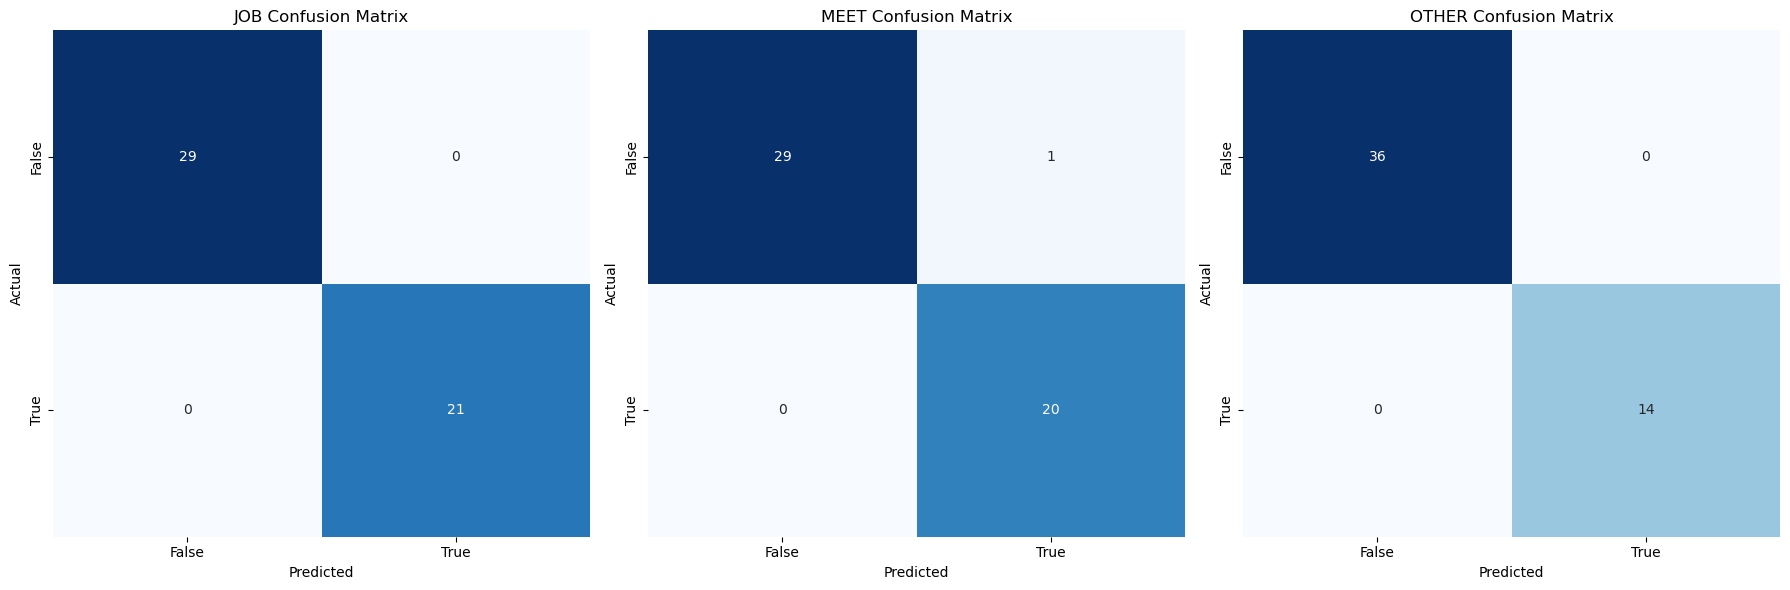

JOB : {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}
MEET : {'precision': 0.9523809523809523, 'recall': 1.0, 'f1': 0.975609756097561, 'accuracy': 0.98}
OTHER : {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}
overall : {'hamming_loss': 0.006666666666666667, 'subset_accuracy': 0.98}


In [15]:
evaluate_models_and_plot(data_df, model_used="mistral")

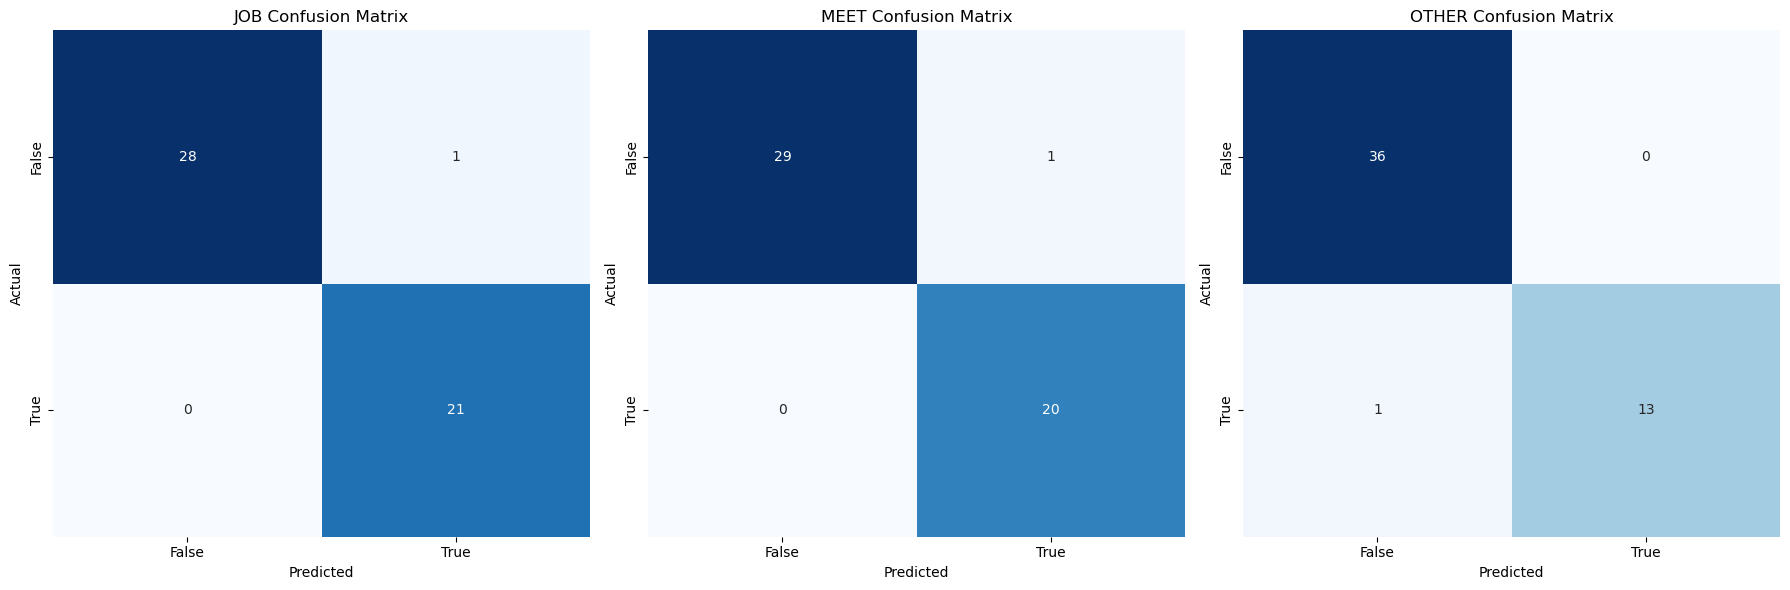

JOB : {'precision': 0.9545454545454546, 'recall': 1.0, 'f1': 0.9767441860465116, 'accuracy': 0.98}
MEET : {'precision': 0.9523809523809523, 'recall': 1.0, 'f1': 0.975609756097561, 'accuracy': 0.98}
OTHER : {'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629, 'accuracy': 0.98}
overall : {'hamming_loss': 0.02, 'subset_accuracy': 0.96}


In [16]:
evaluate_models_and_plot(data_df, model_used="llama")

### Prompt-3 test

In [17]:
prompt3 = """You are an expert email class identification system. Your task is to analyze the provided email and identify if the email falls it each category or not. Your response must be **only** the True/False for each category without any additional text or metadata.

### **Categories**

**1. JOB**
Identify an email as `JOB` if it concerns the status of a specific job application. Recipient of the mail will be informed about the status of their application. This includes notifications that a candidate has:
*   Successfully applied/in the process of applying for a job (application confirmation).
*   Been shortlisted for a position.
*   Been invited to an interview or assessment.
*   Been rejected for a position.
*   Job recommendations or suggestions or ads from job boards, recruiters, companies, etc., do not classify as JOB.

**2. MEET**
Identify an email as `MEET` if the sender is requesting to schedule a meeting, virtual or in-person.
*   Can be a virtual meeting via Zoom, Google Meet, Teams, Video call, etc.
*   Can be an in-person meeting at a specific location.
*   Can be an invitation to job interviews, assessments as well.

**3. OTHER**
Identify an email as `OTHER` only if it does not fit into the `JOB` or `MEET` categories. This includes, but is not limited to:
*   General job-related discussions that are not about application status (e.g., networking, asking about a role, advertisements, job suggestions or requesting for an interview).
*   Newsletters, marketing emails, personal correspondence, etc.

**Important Rules:**
*   An email cannot be identified as any other class if it classifies as OTHER.
*   An email can be identified as either JOB or either MEET or both JOB and MEET.
*   Possible combinations of classes for email are:
    *   JOB, MEET
    *   JOB
    *   MEET
    *   OTHER

### **Output Format**

Your answer must be three True or False values, one for each JOB, MEET and OTHER in this exact order:
<is a JOB>, <is a MEET>, <is OTHER>"""

In [18]:
data_df = df.copy()
data_df[['gemma_JOB', 'gemma_MEET', 'gemma_OTHER']] = (
    data_df['email']
    .apply(lambda x: classify_email(model1, token, prompt3, x))
    .apply(pd.Series)  # convert array to 3 separate columns
)

data_df[['mistral_JOB', 'mistral_MEET', 'mistral_OTHER']] = (
    data_df['email']
    .apply(lambda x: classify_email(model2, token, prompt3, x))
    .apply(pd.Series)  # convert array to 3 separate columns
)

data_df[['llama_JOB', 'llama_MEET', 'llama_OTHER']] = (
    data_df['email']
    .apply(lambda x: classify_email(model3, token, prompt3, x))
    .apply(pd.Series)  # convert array to 3 separate columns
)

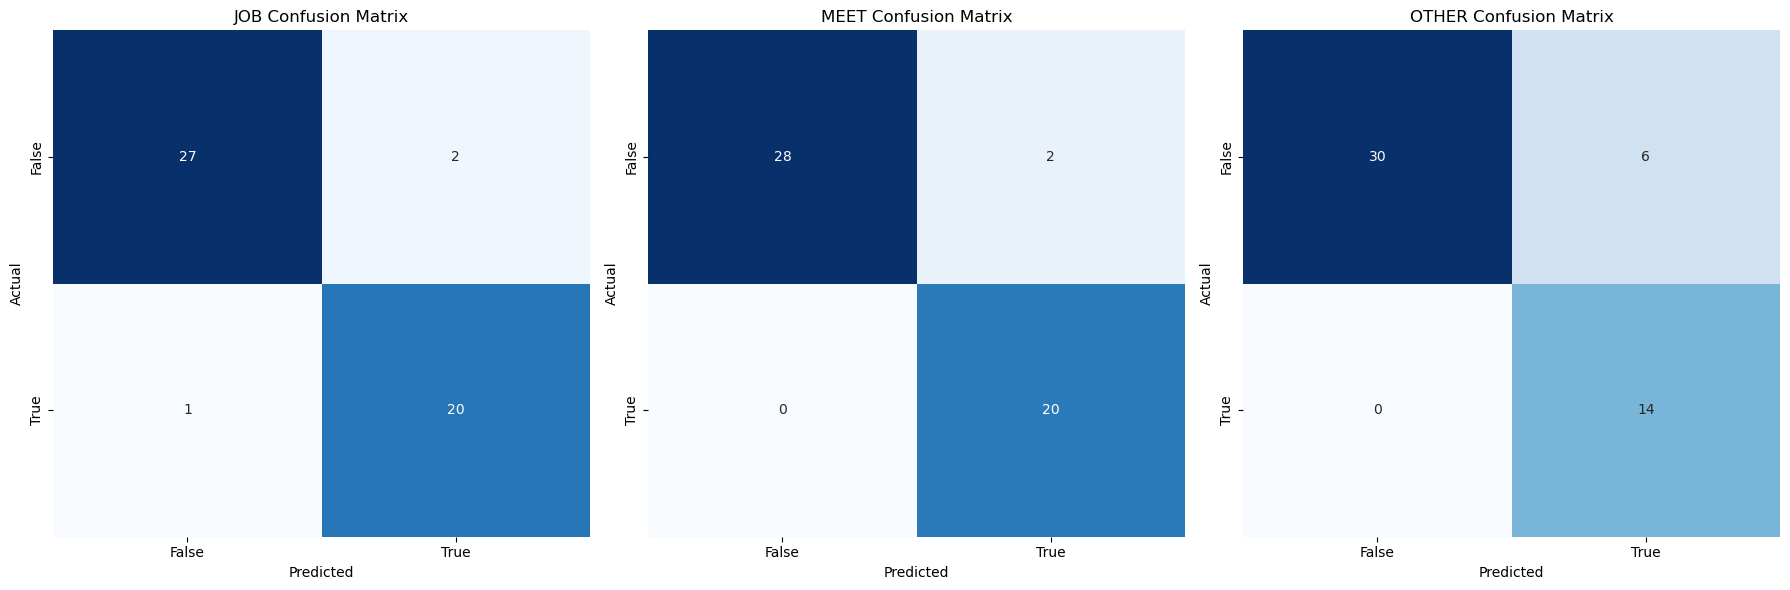

JOB : {'precision': 0.9090909090909091, 'recall': 0.9523809523809523, 'f1': 0.9302325581395349, 'accuracy': 0.94}
MEET : {'precision': 0.9090909090909091, 'recall': 1.0, 'f1': 0.9523809523809523, 'accuracy': 0.96}
OTHER : {'precision': 0.7, 'recall': 1.0, 'f1': 0.8235294117647058, 'accuracy': 0.88}
overall : {'hamming_loss': 0.07333333333333333, 'subset_accuracy': 0.8}


In [19]:
evaluate_models_and_plot(data_df, model_used="gemma")

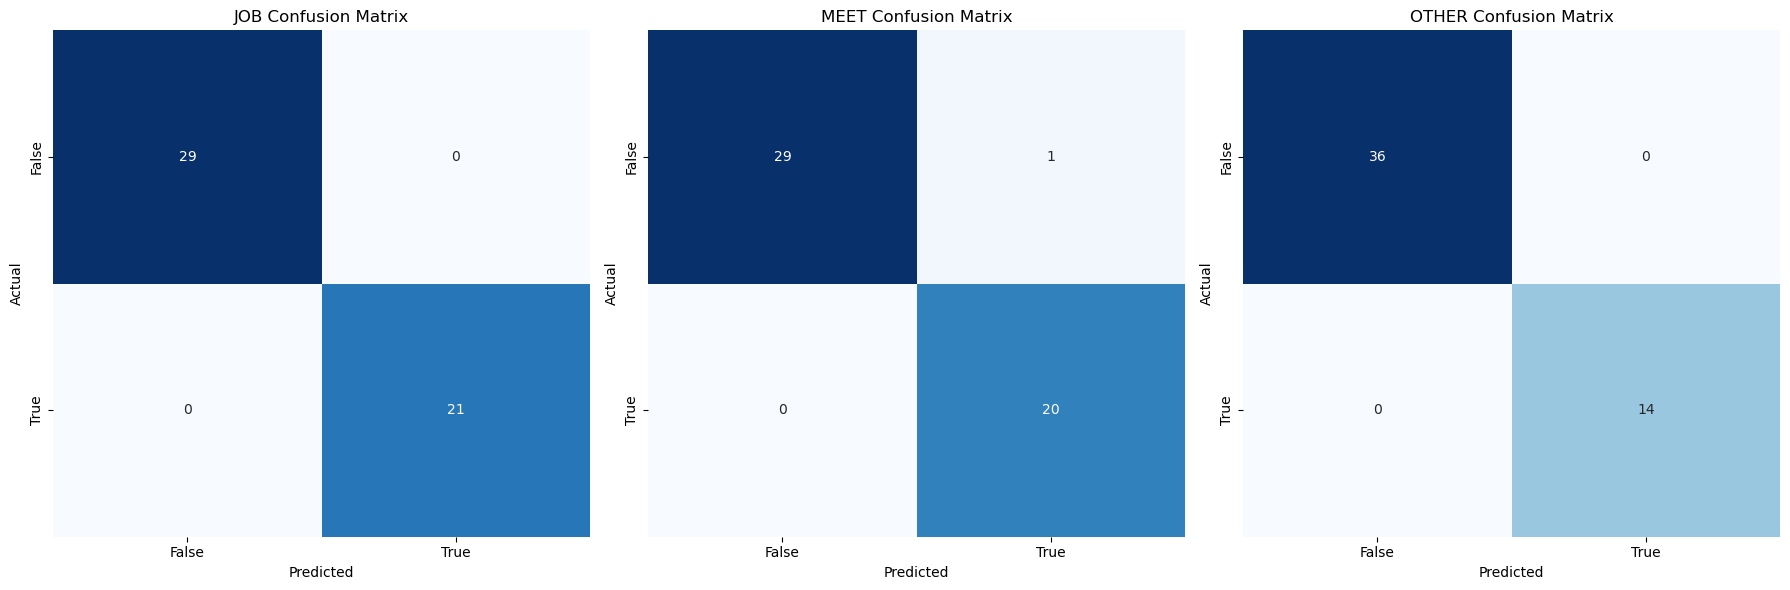

JOB : {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}
MEET : {'precision': 0.9523809523809523, 'recall': 1.0, 'f1': 0.975609756097561, 'accuracy': 0.98}
OTHER : {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}
overall : {'hamming_loss': 0.006666666666666667, 'subset_accuracy': 0.98}


In [20]:
evaluate_models_and_plot(data_df, model_used="mistral")

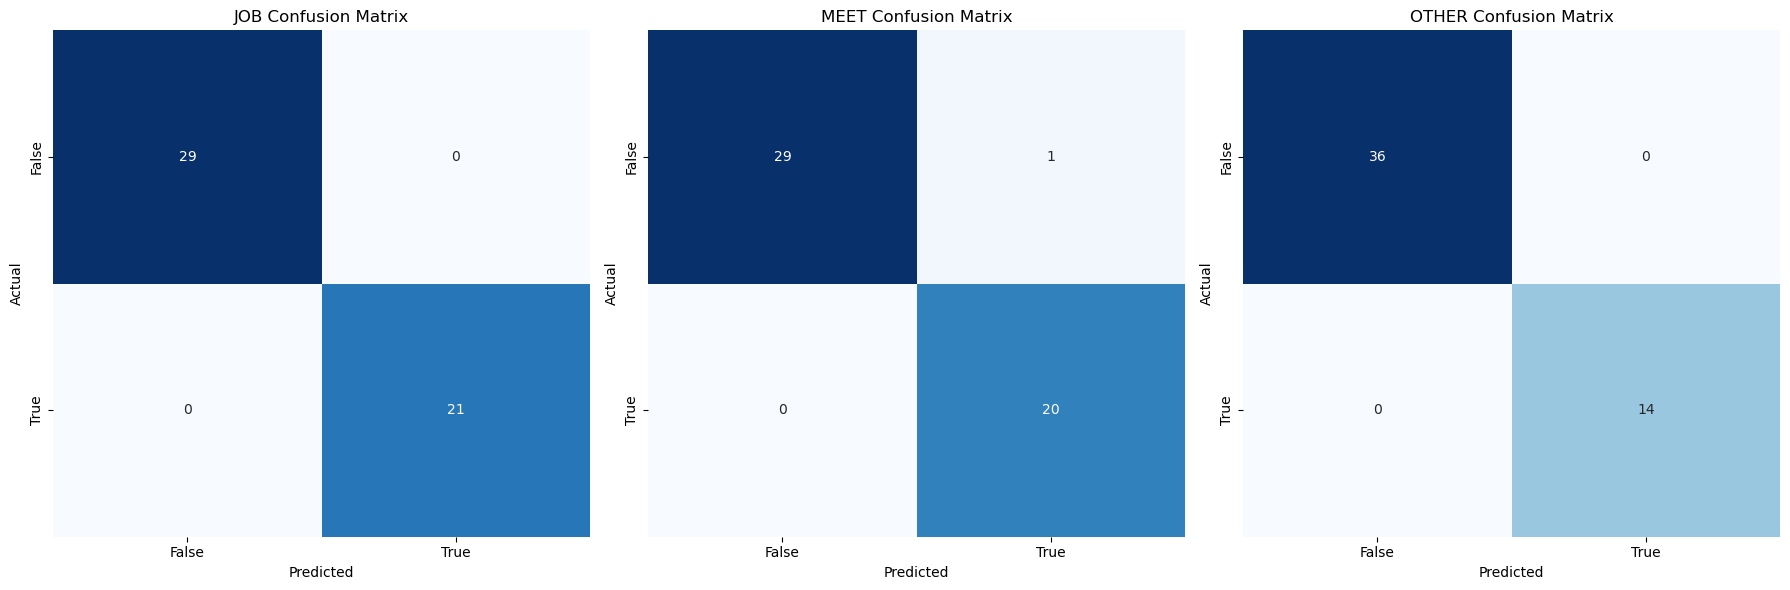

JOB : {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}
MEET : {'precision': 0.9523809523809523, 'recall': 1.0, 'f1': 0.975609756097561, 'accuracy': 0.98}
OTHER : {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}
overall : {'hamming_loss': 0.006666666666666667, 'subset_accuracy': 0.98}


In [21]:
evaluate_models_and_plot(data_df, model_used="llama")

In [49]:
prompt4 = """You are an expert email class identification system. Your task is to analyze the provided email and identify if the email falls it each category or not. Your response must be **only** the True/False for each category without any additional text or metadata.

### **Categories**

**1. JOB**
Identify an email as `JOB` if it concerns the status of a specific job application. Recipient of the mail will be informed about the status of their application. This includes notifications that a candidate has:
*   Successfully applied/in the process of applying for a job (application confirmation).
*   Been shortlisted for a position.
*   Been invited to an interview or assessment.
*   Been rejected for a position.
*   Job recommendations or suggestions or ads from job boards, recruiters, companies, etc., do not classify as JOB.

**2. MEET**
Identify an email as `MEET` if the sender is requesting to schedule a meeting, virtual or in-person.
*   Can be a virtual meeting via Zoom, Google Meet, Teams, Video call, etc.
*   Can be an in-person meeting at a specific location.
*   Can be an invitation to job interviews, assessments as well.
*   Cannot be classified as MEET unless it is mentioned explicitly in the email. Future steps of a process or a job application having a meeting do not classify as MEET.

**3. OTHER**
Identify an email as `OTHER` only if it does not fit into the `JOB` or `MEET` categories. This includes, but is not limited to:
*   General job-related discussions that are not about application status (e.g., networking, asking about a role, advertisements, job suggestions or requesting for an interview).
*   Newsletters, marketing emails, personal correspondence, etc.

**Important Rules:**
*   An email cannot be identified as any other class if it classifies as OTHER.
*   An email can be identified as either JOB or either MEET or both JOB and MEET.
*   Possible combinations of classes for email are:
    *   JOB, MEET
    *   JOB
    *   MEET
    *   OTHER

### **Output Format**

Your answer must be three True or False values, one for each JOB, MEET and OTHER in this exact order:
<is a JOB>, <is a MEET>, <is OTHER>"""

In [50]:
data_df = df.copy()
data_df[['gemma_JOB', 'gemma_MEET', 'gemma_OTHER']] = (
    data_df['email']
    .apply(lambda x: classify_email(model1, token, prompt4, x))
    .apply(pd.Series)  # convert array to 3 separate columns
)

data_df[['mistral_JOB', 'mistral_MEET', 'mistral_OTHER']] = (
    data_df['email']
    .apply(lambda x: classify_email(model2, token, prompt4, x))
    .apply(pd.Series)  # convert array to 3 separate columns
)

data_df[['llama_JOB', 'llama_MEET', 'llama_OTHER']] = (
    data_df['email']
    .apply(lambda x: classify_email(model3, token, prompt4, x))
    .apply(pd.Series)  # convert array to 3 separate columns
)

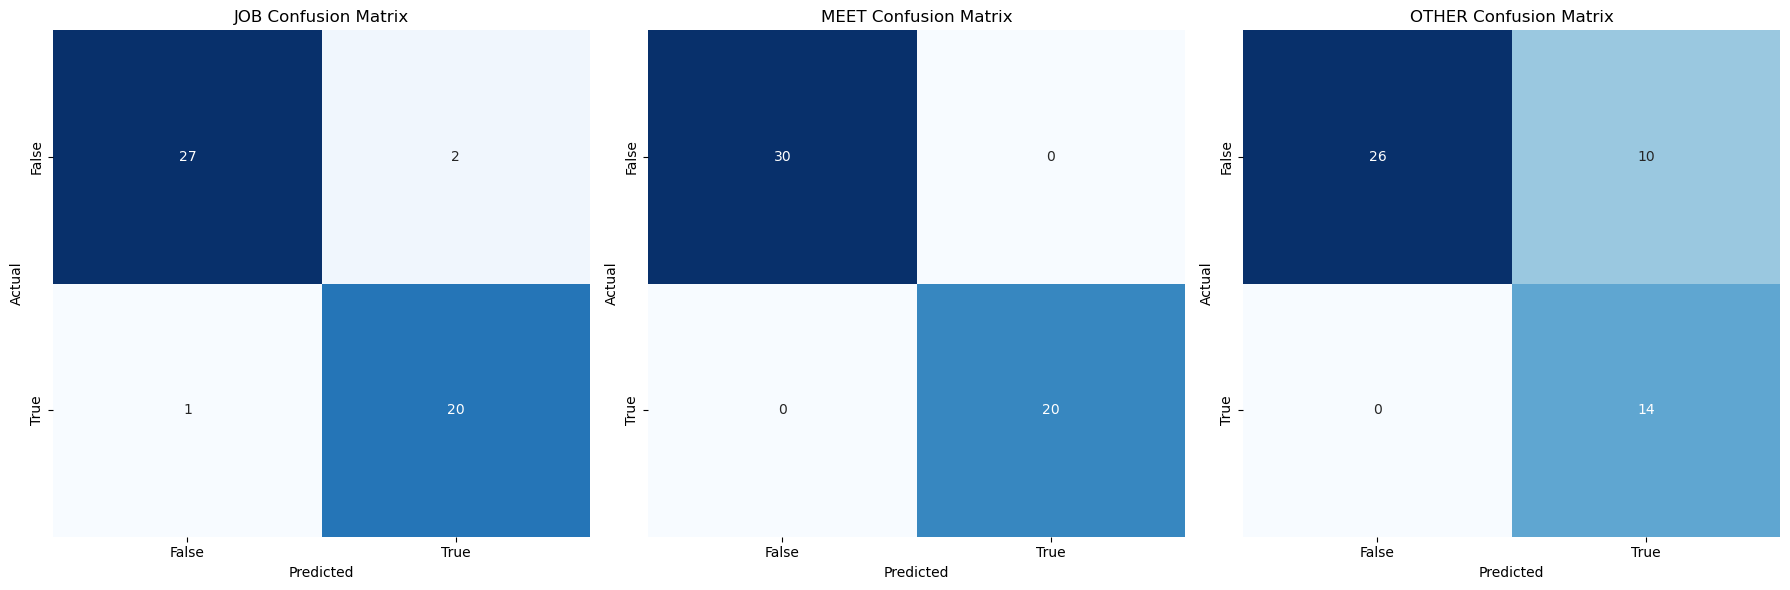

JOB : {'precision': 0.9090909090909091, 'recall': 0.9523809523809523, 'f1': 0.9302325581395349, 'accuracy': 0.94}
MEET : {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}
OTHER : {'precision': 0.5833333333333334, 'recall': 1.0, 'f1': 0.7368421052631579, 'accuracy': 0.8}
overall : {'hamming_loss': 0.08666666666666667, 'subset_accuracy': 0.76}


In [51]:
evaluate_models_and_plot(data_df, model_used="gemma")

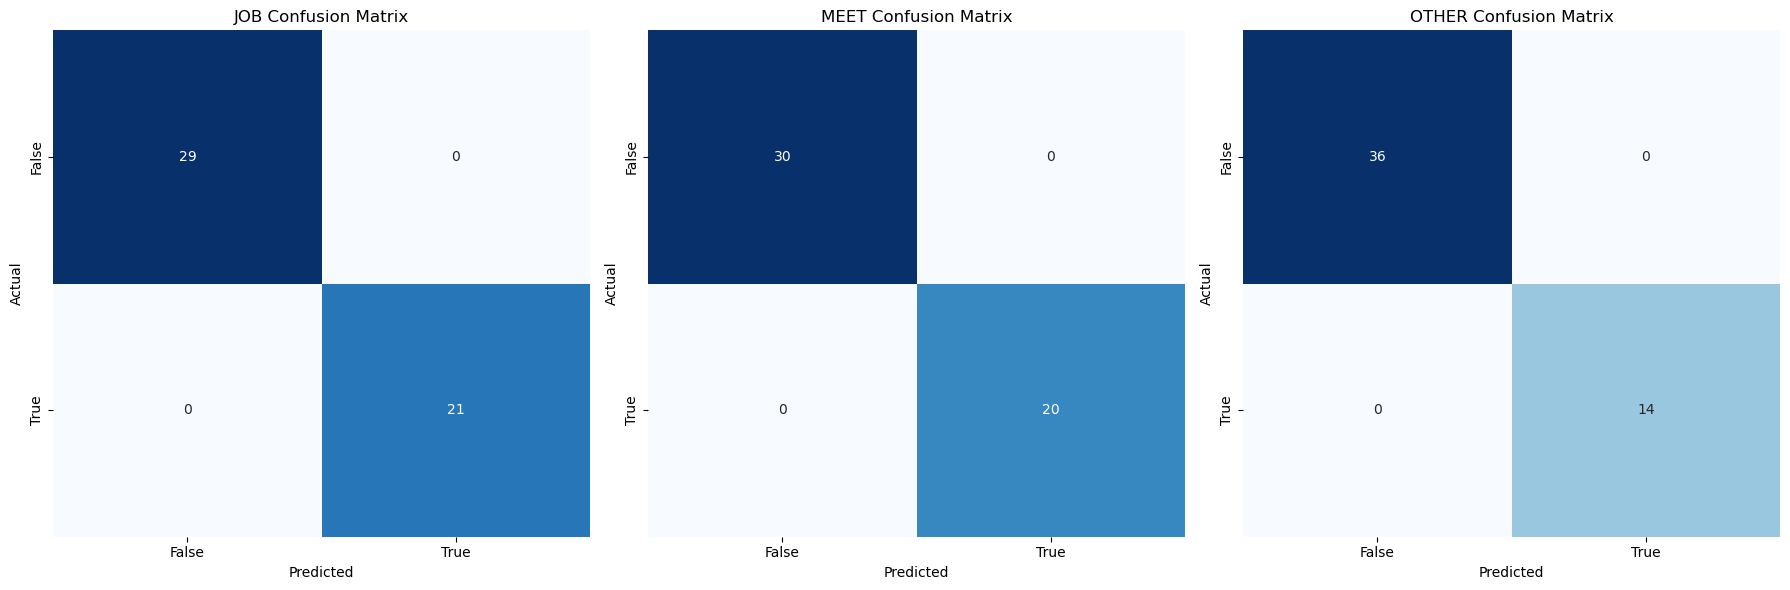

JOB : {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}
MEET : {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}
OTHER : {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}
overall : {'hamming_loss': 0.0, 'subset_accuracy': 1.0}


In [52]:
evaluate_models_and_plot(data_df, model_used="mistral")

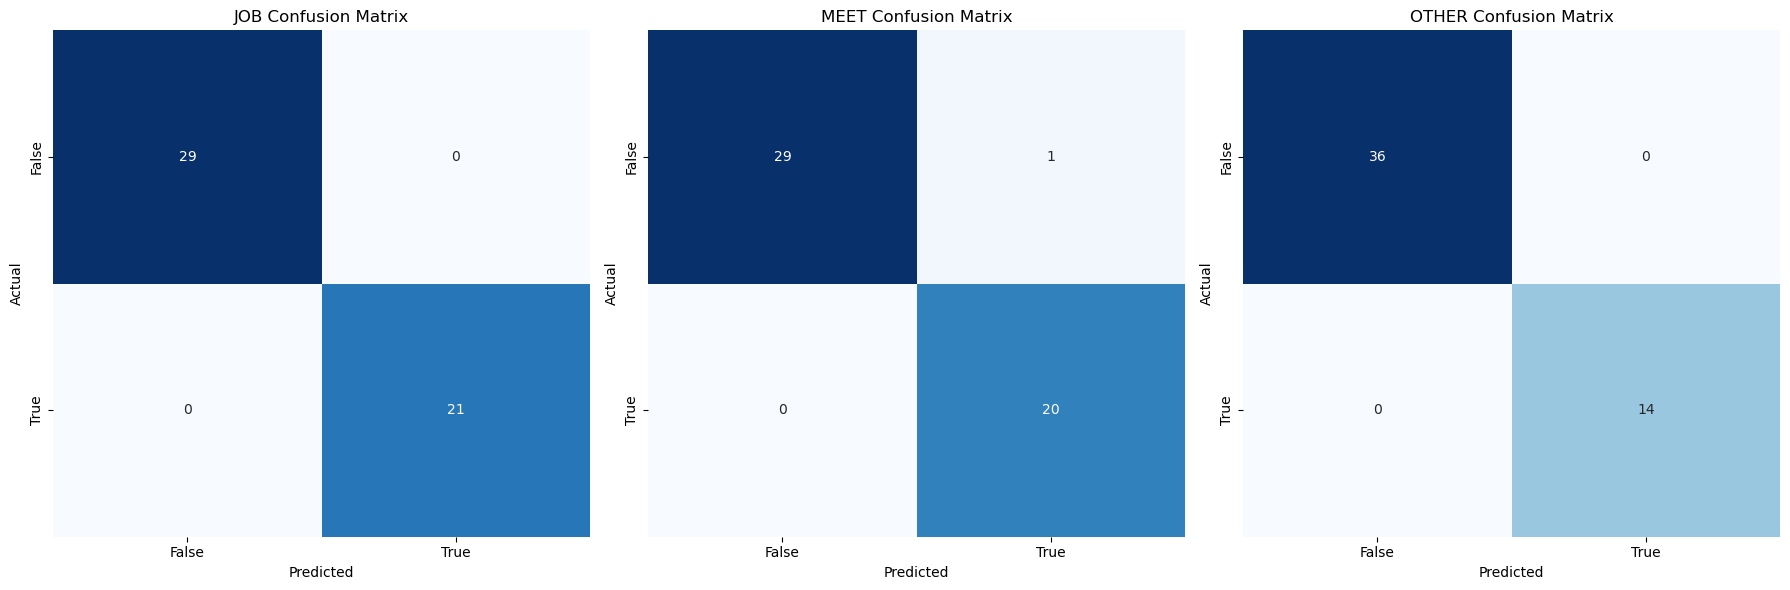

JOB : {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}
MEET : {'precision': 0.9523809523809523, 'recall': 1.0, 'f1': 0.975609756097561, 'accuracy': 0.98}
OTHER : {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}
overall : {'hamming_loss': 0.006666666666666667, 'subset_accuracy': 0.98}


In [53]:
evaluate_models_and_plot(data_df, model_used="llama")

In [54]:
data_df[['email','MEET','mistral_MEET','llama_MEET']]

,email,MEET,mistral_MEET,llama_MEET
0,"Hi Saideep,\n\nThanks for your interest in iSp...",False,False,False
1,"Hello, Saideep,\n\nWe received your job applic...",False,False,False
2,"Hi Saideep,\n\nWe're super-pumped that you sha...",False,False,True
3,"Hi Saideep,\n\nThank you for applying to the S...",False,False,False
4,"Hello Saideep,\n\nThank you for your interest ...",False,False,False
5,"Dear Saideep,\n\nThank you for your interest i...",False,False,False
6,"Dear Saideep,\n\nThank you for your interest i...",False,False,False
7,"Hi Saideep,\nThank you for your interest in th...",False,False,False
8,"Hi Saideep,\n\nThanks for your interest in Red...",False,False,False
9,"Dear Saideep,\n\nThank you for giving us the o...",False,False,False
